In [1]:
import numpy as np
import netCDF4
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from esem import rf_model
from esem.utils import leave_one_out
import joblib

import utils

2025-12-03 15:48:15.152532: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 15:48:15.205429: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 15:48:17.046216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_files = ["historical", "ssp126", "ssp370", 'hist-aer', 'hist-GHG']
tasFiles = ["historical", "ssp126", "ssp370", "hist-aer", "hist-GHG"]
# Create training and testing arrays
X, solvers = utils.create_predictor_data(train_files)
Y = utils.create_predictdand_data(tasFiles)

In [3]:
rfTas = RandomForestRegressor(random_state=0)
rfPr = RandomForestRegressor(random_state=0)
rfPr90 = RandomForestRegressor(random_state=0)
rfDTR = RandomForestRegressor(random_state=0)

In [4]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [5]:
# Define hyperparameters
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [6]:
# Randomized hyperparameter search
rfTasRandom = RandomizedSearchCV(estimator = rfTas, param_distributions = random_grid, n_iter = 29, cv = 3, verbose=2, n_jobs = -1)
rfPrRandom = RandomizedSearchCV(estimator = rfPr, param_distributions = random_grid, n_iter = 29, cv = 3, verbose=2, n_jobs = -1)
rfPr90Random = RandomizedSearchCV(estimator = rfPr90, param_distributions = random_grid, n_iter = 29, cv = 3, verbose=2, n_jobs = -1)
rfDTRRandom = RandomizedSearchCV(estimator = rfDTR, param_distributions = random_grid, n_iter = 29, cv = 3, verbose=2, n_jobs = -1)

In [7]:
Y.compute()

<xarray.Dataset> Size: 184MB
Dimensions:                    (time: 667, lat: 96, lon: 144)
Coordinates:
  * lat                        (lat) float64 768B -90.0 -88.11 ... 88.11 90.0
  * lon                        (lon) float64 1kB 0.0 2.5 5.0 ... 355.0 357.5
  * time                       (time) int64 5kB 1850 1851 1852 ... 2013 2014
    quantile                   float64 8B 0.9
Data variables:
    diurnal_temperature_range  (time, lat, lon) float32 37MB 0.03264 ... -0.3354
    tas                        (time, lat, lon) float32 37MB 0.32 ... 2.611
    pr                         (time, lat, lon) float32 37MB 0.02337 ... 0.04197
    pr90                       (time, lat, lon) float64 74MB 0.02468 ... 0.08654

In [3]:
# Stack lat/lon grids into a single flattened dimension called "space"
# so each time step becomes a 1D vector of all grid cells.
y_inp_tas  = Y["tas"].stack(space=("lat", "lon"))
y_inp_pr   = Y["pr"].stack(space=("lat", "lon"))
y_inp_pr90 = Y["pr90"].stack(space=("lat", "lon"))
y_inp_dtr  = Y["diurnal_temperature_range"].stack(space=("lat", "lon"))

In [8]:
rf_tas = rfTasRandom.fit(X, y_inp_tas)

Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=  51.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time=  30.4s


/glade/u/home/okyang/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=  45.8s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=250; total time=  59.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=8, min_samples_split=25, n_estimators=100; total time=  14.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=8, min_samples_split=25, n_estimators=100; total time=  14.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=8, min_samples_split=25, n_estimators=100; total time=  16.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=250; total time= 1.0min
[CV] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=  46.8s
[CV] END bootstrap=False, max_dep

In [9]:
joblib.dump(rf_tas, "model.pkl")

['model.pkl']

In [10]:
rf_pr = rfPrRandom.fit(X, y_inp_pr)

Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=  30.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time=  40.6s


/glade/u/home/okyang/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=  32.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time=  40.1s
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=12, min_samples_split=10, n_estimators=100; total time=  25.4s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  49.2s
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=200; total time=  46.1s
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=12, min_samples_split=10, n_estimators=100; total time=  23.1s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  44.1s
[CV] END bootstrap=False, max_depth=3

In [11]:
joblib.dump(rf_pr, "modelpr.pkl")

['modelpr.pkl']

In [12]:
rf_pr90 = rfPr90Random.fit(X, y_inp_pr90)

Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=100; total time=  23.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=100; total time=  23.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=100; total time=  26.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=  54.9s


/glade/u/home/okyang/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time= 1.6min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=150; total time=  40.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time= 1.4min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 1.0min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=150; total time=  44.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=12, min_samples_split=25, n_estimators=300; total time= 1.2min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=250; total time= 1.5min
[CV] END bootstrap=False, max_de

In [13]:
joblib.dump(rf_pr90, "modelpr90.pkl")

['modelpr90.pkl']

In [14]:
rf_dtr = rfDTRRandom.fit(X, y_inp_dtr)

Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=200; total time= 1.2min
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=100; total time=  13.5s
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=100; total time=  13.7s
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=100; total time=  14.6s
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=200; total time=  31.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=  34.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=

/glade/u/home/okyang/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [15]:
joblib.dump(rf_dtr, "modeldtr.pkl")

['modeldtr.pkl']

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=300; total time=  39.0s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=150; total time=  40.0s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=25, n_estimators=300; total time= 1.2min
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=25, n_estimators=100; total time=  13.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=25, n_estimators=100; total time=  13.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=150; total time=  35.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=100; total time=  30.4s
[CV] END bootstrap=False, max_depth=45, m

In [3]:
X_test = utils.get_test_data('ssp245', solvers)
Y_test = utils.create_predictdand_data(['ssp245'])

In [4]:
tas_truth = Y_test["tas"]
pr_truth = Y_test["pr"]
pr90_truth = Y_test["pr90"]
dtr_truth = Y_test["diurnal_temperature_range"]

In [5]:
# loading saved models

rf_tas = joblib.load("modeltas.pkl")
rf_pr = joblib.load("modelpr.pkl")
rf_pr90 = joblib.load("modelpr90.pkl")
rf_dtr = joblib.load("modeldtr.pkl")


In [6]:
m_out_t = rf_tas.predict(X_test)

In [7]:
m_out_p = rf_pr.predict(X_test)
m_out_p90 = rf_pr90.predict(X_test)
m_out_d = rf_dtr.predict(X_test)

In [8]:
m_out_tas = m_out_t.reshape(86, 96, 144)
m_out_pr = m_out_p.reshape(86, 96, 144)
m_out_pr90 = m_out_p90.reshape(86, 96, 144)
m_out_dtr = m_out_d.reshape(86, 96, 144)

Y_test

<xarray.Dataset> Size: 24MB
Dimensions:                    (time: 86, lat: 96, lon: 144)
Coordinates:
  * lat                        (lat) float64 768B -90.0 -88.11 ... 88.11 90.0
  * lon                        (lon) float64 1kB 0.0 2.5 5.0 ... 355.0 357.5
  * time                       (time) int64 688B 2015 2016 2017 ... 2099 2100
    quantile                   float64 8B ...
Data variables:
    diurnal_temperature_range  (time, lat, lon) float32 5MB 0.09798 ... -0.4339
    tas                        (time, lat, lon) float32 5MB 1.475 ... 5.266
    pr                         (time, lat, lon) float32 5MB 0.03122 ... 0.1588
    pr90                       (time, lat, lon) float64 10MB 0.0755 ... 0.4202

In [9]:
xr_output=xr.Dataset(coords={'time': Y_test.time.values, 'lat': Y_test.lat.values, 'lon': Y_test.lon.values}) 
xr_output["tas"]=(['time', 'lat', 'lon'], m_out_tas) 
xr_output["diurnal_temperature_range"]=(['time', 'lat', 'lon'], m_out_dtr) 
xr_output["pr"]=(['time', 'lat', 'lon'], m_out_pr) 
xr_output["pr90"]=(['time', 'lat', 'lon'], m_out_pr90)

In [11]:
print(f"NRMSE spatial tas: {utils.nrmse_spatial(tas_truth[65:], xr_output['tas'][65:]).mean()}")
print(f"NRMSE global tas: {utils.nrmse_global(tas_truth[65:], xr_output['tas'][65:]).mean()}")
print(f"NRMSE total tas: {utils.nrmse_total(tas_truth[65:], xr_output['tas'][65:]).mean()}")

NRMSE spatial tas: 0.5736092252907253
NRMSE global tas: 0.4820852189124067
NRMSE total tas: 2.9840353198527594


In [13]:
print(f"NRMSE spatial dtr: {utils.nrmse_spatial(dtr_truth[65:], xr_output['diurnal_temperature_range'][65:]).mean()}")
print(f"NRMSE global dtr: {utils.nrmse_global(dtr_truth[65:], xr_output['diurnal_temperature_range'][65:]).mean()}")
print(f"NRMSE total dtr: {utils.nrmse_total(dtr_truth[65:], xr_output['diurnal_temperature_range'][65:]).mean()}")

NRMSE spatial dtr: 27.1208592561128
NRMSE global dtr: 4.661181316689424
NRMSE total dtr: 50.426765839559906


In [14]:
print(f"NRMSE spatial pr: {utils.nrmse_spatial(pr_truth[65:], xr_output['pr'][65:]).mean()}")
print(f"NRMSE global pr: {utils.nrmse_global(pr_truth[65:], xr_output['pr'][65:]).mean()}")
print(f"NRMSE total pr: {utils.nrmse_total(pr_truth[65:], xr_output['pr'][65:]).mean()}")

NRMSE spatial pr: 10.449939420441694
NRMSE global pr: 0.8921128245388916
NRMSE total pr: 14.910503543136153


In [15]:
print(f"NRMSE spatial pr90: {utils.nrmse_spatial(pr90_truth[65:], xr_output['pr90'][65:]).mean()}")
print(f"NRMSE global pr90: {utils.nrmse_global(pr90_truth[65:], xr_output['pr90'][65:]).mean()}")
print(f"NRMSE total pr90: {utils.nrmse_total(pr90_truth[65:], xr_output['pr90'][65:]).mean()}")

NRMSE spatial pr90: 13.21140710346982
NRMSE global pr90: 0.8893001144738653
NRMSE total pr90: 17.65790767583915


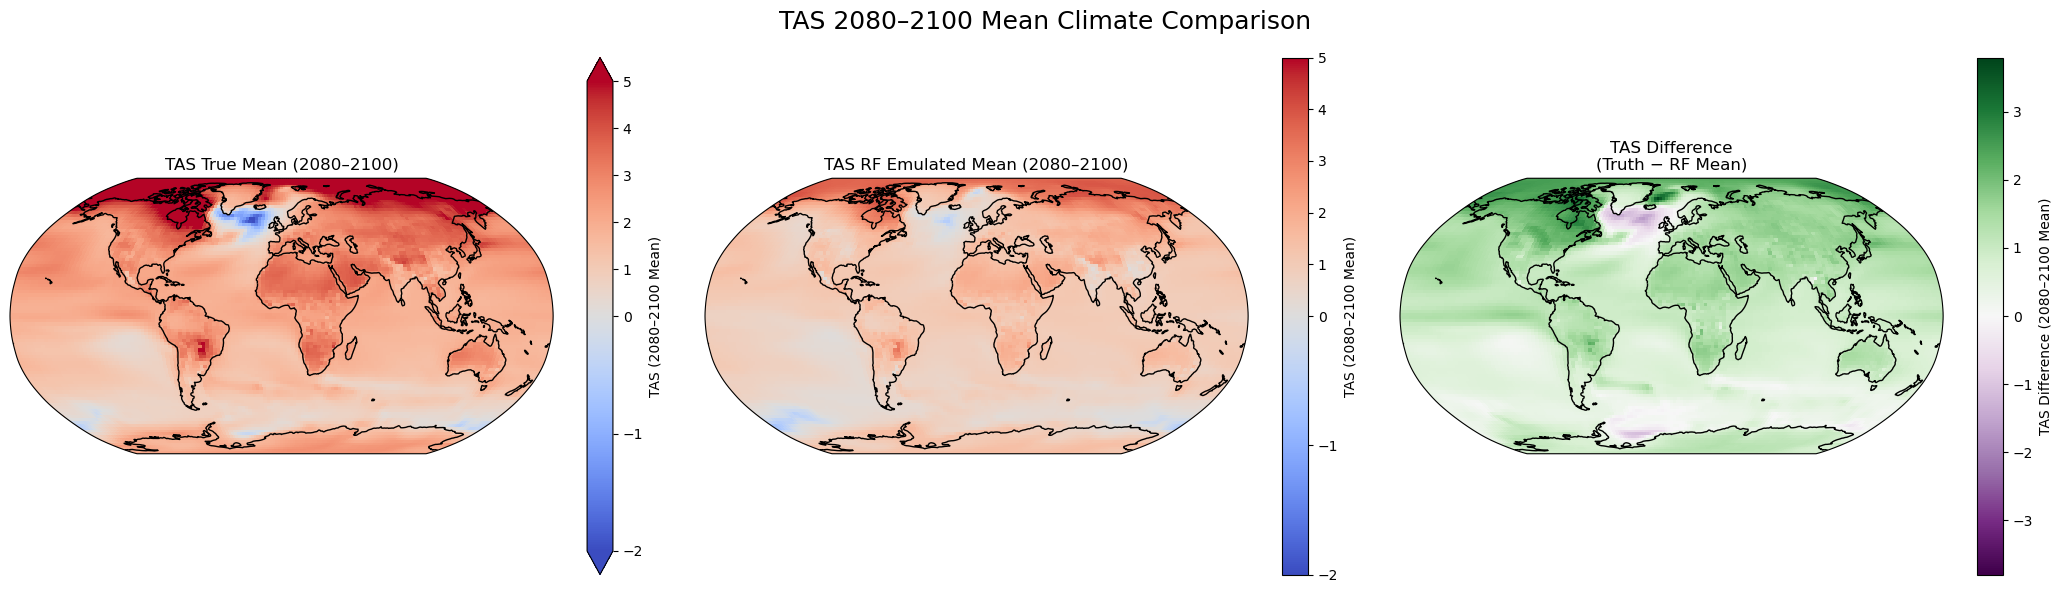

In [18]:
utils.plot_mean_2080_2100(tas_truth, xr_output["tas"], "TAS", savefig = True, Model = "RF")

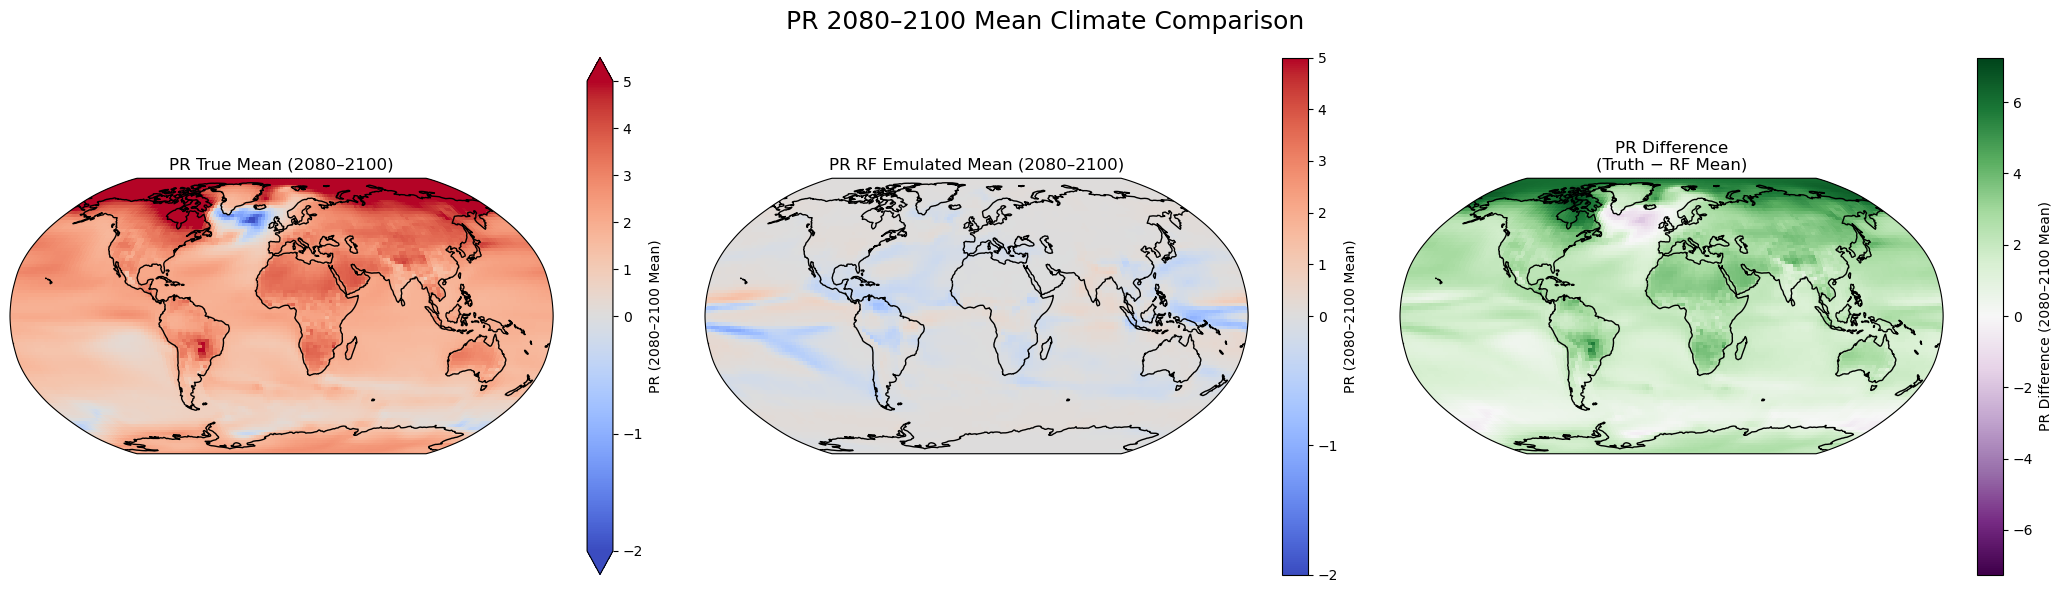

In [19]:
utils.plot_mean_2080_2100(tas_truth, xr_output["pr"], "PR", savefig = True,  Model = "RF")

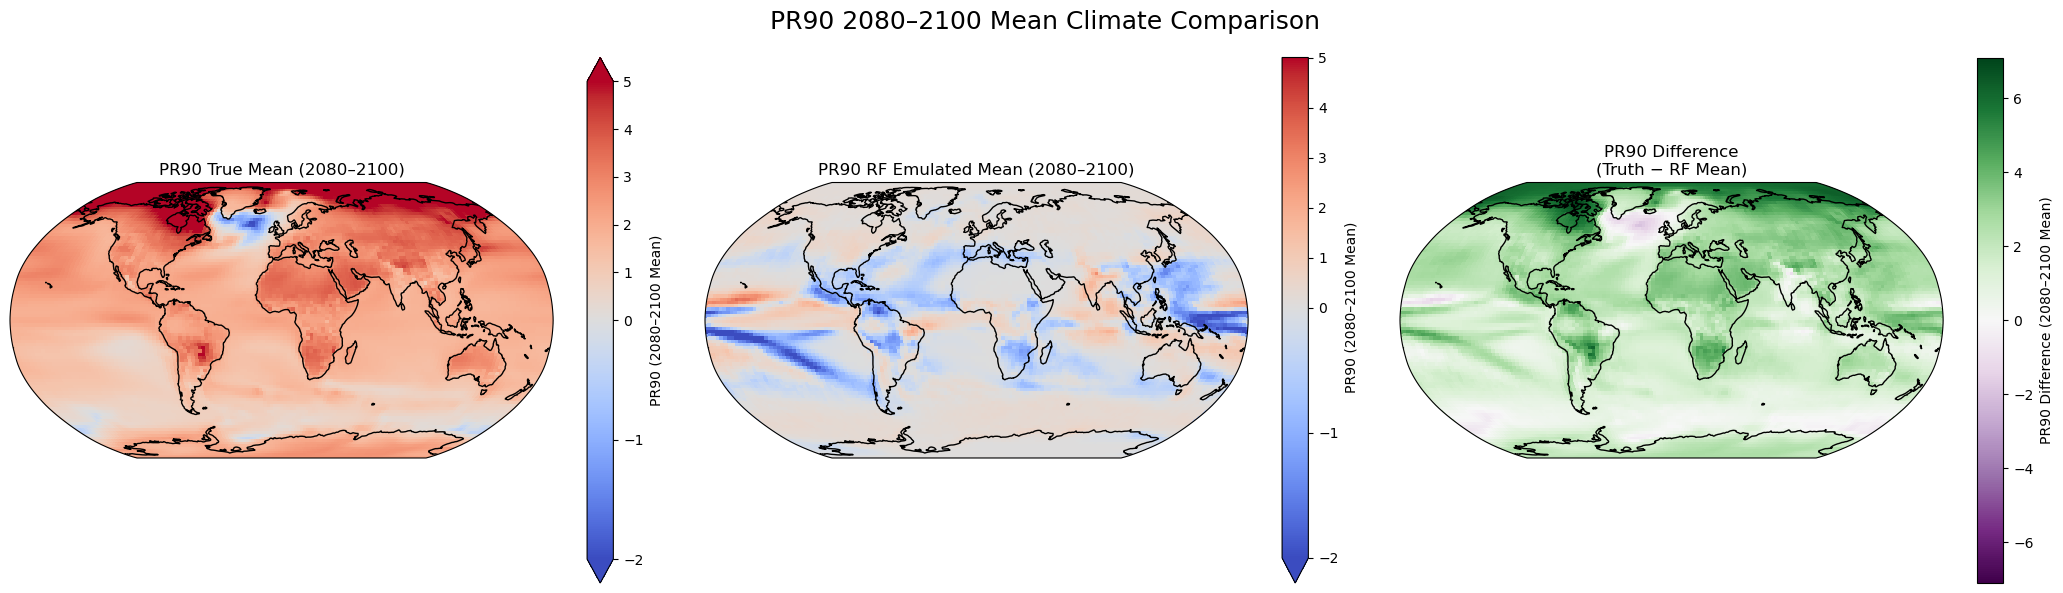

In [20]:
utils.plot_mean_2080_2100(tas_truth, xr_output["pr90"], "PR90", savefig = True, Model = "RF")

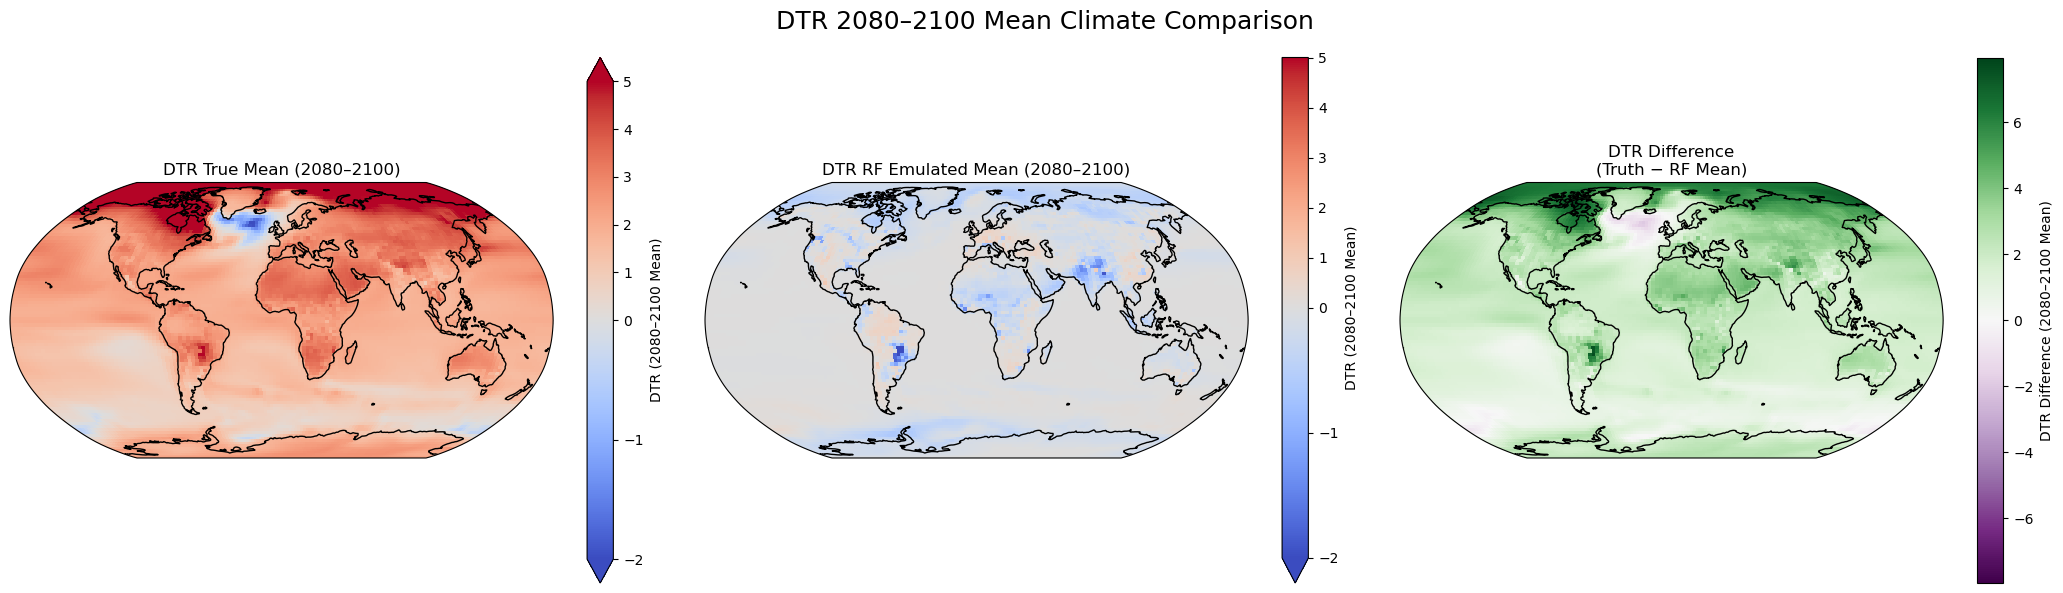

In [21]:
utils.plot_mean_2080_2100(tas_truth, xr_output["diurnal_temperature_range"], "DTR", savefig = True, Model = "RF")